## Multisource M1 model for Marmousi data

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sys
import time

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import PIL

from include import *
from pysit import *
from pysit.gallery import marmousi
from pysit.gallery import marmousi2
#from pysit.gallery import bp

import deepwave

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

import scipy.ndimage

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(7)
    device = torch.device('cuda:7')  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

## Loading Data: Marmousi Velocity Model

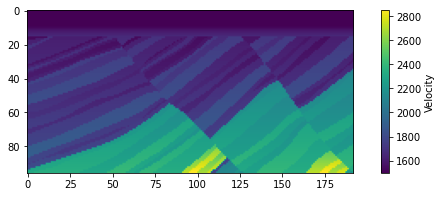

In [2]:
vp_true, vp_init, m, d = marmousi2(origin=(7500, 355), 
                        size=(1910, 950), 
                        pixel_scale="small",
                        initial_model_style="gradient",
                        initial_config={'min':1500.0,'max':3000.0})


plot_shape = m.shape(as_grid=True)
vp_true_np = vp_true.reshape(plot_shape).T

fig1 = plt.figure(figsize=(10,3))

#Changing to tensor
vp_true_var = torch.tensor(vp_true_np)
model_true = vp_true_var.clone().to(device)
model_true_var = model_true[None,None,...].type(dtype)
model_true_var = model_true_var.to(device)

vmin_true = torch.min(model_true_var)
vmax_true = torch.max(model_true_var)

vp_init_np = scipy.ndimage.gaussian_filter(model_true_var.cpu().detach().numpy(),
                                           sigma=15).squeeze()


plt.imshow(model_true_var.detach().cpu().numpy().squeeze())
plt.colorbar(label='Velocity')
#plt.clim(1000,3000)

vp_init = torch.tensor(vp_init_np)
model_init = vp_init.clone()

torch.Size([1, 1, 96, 192])


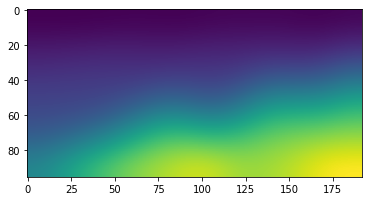

In [3]:
min_vel = torch.min(model_init)
max_vel = torch.max(model_init)

model_init = (model_init - min_vel)/(max_vel - min_vel)

plt.imshow(model_init)

model_init_var = model_init[None,None,...].type(dtype).to(device)

output_depth = model_init_var.shape[1]
print(model_init_var.shape)
#model_init_var.requires_grad = True



## Acquisition Setup


In [4]:
# Model setup for DeepWave
dx = m.deltas[0]
nz, ny = vp_true_np.shape
num_dims = 2

# acquisition setup
num_shots = 20

num_sources_per_shot = 1
source_spacing = ny*dx / num_shots #10.0

num_receivers_per_shot = 96
receiver_spacing = ny*dx / num_receivers_per_shot #10.0

peak_freq = 10
dt = 0.004 # 4ms

n_seconds = 4
nt = int(n_seconds / dt)

In [5]:
#Build acquisition data

# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [6]:
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), 
                                dt).cpu()

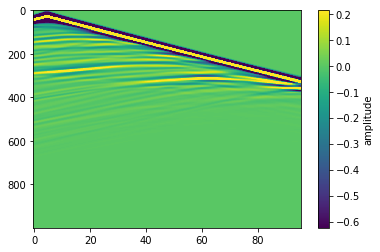

In [7]:
# Plot one shot gather
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_true[:,1].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')

In [8]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.

rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [9]:
num_channels = [128]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=True).type(dtype).to(device)

mse_n, mse_t, ni, _net, loss_list = fit_wrapper.fit(num_channels=num_channels,
                        reg_noise_std=0.0,
                        LR=0.01,
                        num_iter=400,
                        img_noisy_var=model_init_var,
                        net=net,
                        net_input=None,
                        img_clean_var=model_true_var,
                        find_best=True)



Uniform Noise Shape:  [1, 128, 3, 6]
<generator object Module.parameters at 0x7faa2390d200>
optimize with adam 0.01
Iteration 0.000000     Train loss 0.127852
Iteration 50.000000     Train loss 0.000257
Iteration 100.000000     Train loss 0.000054
Iteration 150.000000     Train loss 0.000029
Iteration 200.000000     Train loss 0.000019
Iteration 250.000000     Train loss 0.000012
Iteration 300.000000     Train loss 0.000016
Iteration 350.000000     Train loss 0.000008


## FWI Optimization

In [10]:
scale = torch.tensor(1000.).to(device)
offset = torch.tensor(1500.).to(device)

scale.requires_grad = True
offset.requires_grad = True

params = [p for p in _net.parameters()]

norm_param = [scale, offset]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

# c1 = 0.7 and c2 = 0.3 give best result

c1 = 0.4 
c2 = 0.6

optimizer = torch.optim.Adam([{'params':params, 'lr':1e-4},{'params':norm_param, 'lr': 10}])
#scheduler = ExponentialLR(optimizer, gamma=0.9)

#,{'params':norm_param, 'lr': 1e-4}

In [11]:
# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
# This initial guess is shifted in frequency from the true one
source_amplitudes_init = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [12]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
# I take the absolute value of the maximum and add a small positive value
# (1e-10) to ensure that the denominator is never zero
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / (rcv_amps_true_max.abs() + 1e-10)

Model L2 Loss - 14122.1279296875, 	 Model L1 Loss - 86.40139770507812




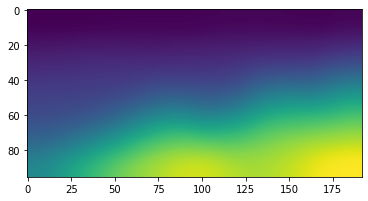

Model L2 Loss - 12993.3359375, 	 Model L1 Loss - 71.62185668945312




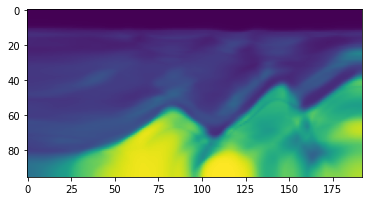

Model L2 Loss - 11847.6376953125, 	 Model L1 Loss - 65.53567504882812




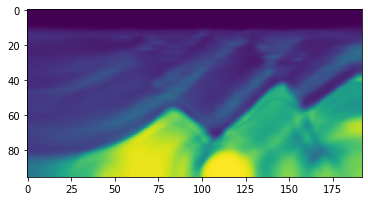

Model L2 Loss - 13402.8720703125, 	 Model L1 Loss - 65.9026107788086




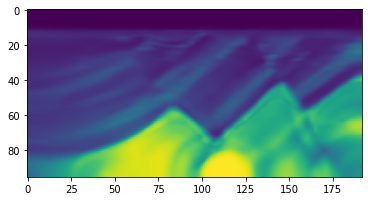

Model L2 Loss - 12771.998046875, 	 Model L1 Loss - 62.15616226196289




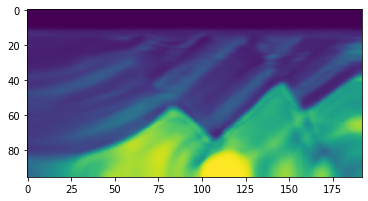

In [ ]:
# Iterative inversion loop just FWI
t_start = time.time()
num_batches = 10 # split data into 10 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
num_epochs = 10000 # Pass through the entire dataset 30 times
#vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting


epoch_amp_loss_list=[]
model_l2_loss = []
model_l1_loss = []
count=0
   
for epoch in range(num_epochs):
    
    if(epoch%500 == 0):
        with torch.no_grad():
            norm_vel_var = _net(ni.type(dtype))        
            norm_vel_var = norm_vel_var.squeeze()
            norm_vel_np = norm_vel_var.data.cpu().numpy()
            
            norm_vel_var = torch.flatten(norm_vel_var)
            unnorm_vel_var = (scale)*norm_vel_var + (offset)

            unnorm_vel_var = unnorm_vel_var.reshape(96,192)
            
            curr_l2_loss = l2_loss(unnorm_vel_var, model_true)
            curr_l1_loss = l1_loss(unnorm_vel_var, model_true)
            
            print('Model L2 Loss - {curr_l2_loss}, \t Model L1 Loss - {curr_l1_loss}'.format(
                curr_l2_loss=curr_l2_loss, curr_l1_loss=curr_l1_loss))
            
            print('\n')
            
            model_l2_loss.append(curr_l2_loss.item())
            model_l1_loss.append(curr_l1_loss.item())
            
            plt.imshow(unnorm_vel_var.detach().cpu().numpy())
            plt.show()
        
    epoch_loss2 = 0
    for it in range(num_batches):
        optimizer.zero_grad()
        
        # norm_vel_var = torch.fft.ifft2(_net(ni.type(dtype))).abs()
        norm_vel_var = _net(ni.type(dtype))
        norm_vel_var = norm_vel_var.squeeze()
        norm_vel_np = norm_vel_var.data.cpu().numpy()
    
        norm_vel_var = torch.flatten(norm_vel_var)
        unnorm_vel_var = (scale)*norm_vel_var + (offset)

        unnorm_vel_var = unnorm_vel_var.reshape(96,192)
        
        prop = deepwave.scalar.Propagator({'vp': unnorm_vel_var}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
        
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)
        
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        
        # Normalize amplitudes by dividing by the maximum amplitude of each receiver
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / (batch_rcv_amps_pred_max.abs())
        
        loss1 = l1_loss(batch_rcv_amps_pred_norm, batch_rcv_amps_true)
        loss2 = l2_loss(batch_rcv_amps_pred_norm, batch_rcv_amps_true)
        
        pixel_loss = c1*loss1 + c2*loss2
        
        epoch_loss2 += pixel_loss.item()
        
        pixel_loss.backward()
        # print(epoch,'-', it, '-', pixel_loss.grad)
        optimizer.step()
    
    #scheduler.step()
    epoch_amp_loss_list.append(epoch_loss2)  

    
t_end = time.time()
print('Runtime:', t_end - t_start)

In [ ]:
norm_vel_var = _net(ni.type(dtype)).to(device)
norm_vel_var = norm_vel_var.squeeze().to(device)
norm_vel_np = norm_vel_var.data.cpu().numpy()

norm_vel_var = torch.flatten(norm_vel_var).to(device)
unnorm_vel_var = (scale*norm_vel_var + offset).to(device)

unnorm_vel_var = unnorm_vel_var.reshape(96,192).to(device)

prop = deepwave.scalar.Propagator({'vp': unnorm_vel_var}, dx).to(device)


receiver_amplitudes_pred = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), 
                                dt).cpu()

vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_true[:,2].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)
plt.colorbar(label="Amplitude Value")
plt.clim(-0.25, 0.25)

In [ ]:
vmin, vmax = np.percentile(receiver_amplitudes_pred[:,1].detach().cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_pred[:,2].detach().cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)
plt.colorbar(label="Amplitude Value")
plt.clim(-0.25, 0.25)

In [ ]:
man_loss = torch.mean(torch.abs(receiver_amplitudes_pred - receiver_amplitudes_true))

In [ ]:
print(man_loss)

In [ ]:
epoch_amp_loss_np = np.array(epoch_amp_loss_list)
epoch_amp_loss_np_norm = epoch_amp_loss_np/np.max(epoch_amp_loss_np)

model_l2_loss_np = np.array(model_l2_loss)
model_l2_loss_np_norm = model_l2_loss_np/np.max(model_l2_loss_np)

model_l1_loss_np = np.array(model_l1_loss)
model_l1_loss_np_norm = model_l1_loss_np/np.max(model_l1_loss_np)

In [ ]:
fig1 = plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(epoch_amp_loss_np_norm)
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude Pixel Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(3,1,2)
plt.plot(model_l2_loss_np_norm)
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Model L2 Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(3,1,3)
plt.plot(model_l1_loss_np_norm)
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Model L1 Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig('V2_loss_5.png')
plt.show()

In [ ]:
with torch.no_grad():
    norm_vel_var = _net(ni.type(dtype))        
    norm_vel_var = norm_vel_var.squeeze()
    norm_vel_np = norm_vel_var.data.cpu().numpy()

    norm_vel_var = torch.flatten(norm_vel_var)
    unnorm_vel_var = (scale)*norm_vel_var + (offset)

    unnorm_vel_var = unnorm_vel_var.reshape(96,192)
    
    plt.imshow(unnorm_vel_var.detach().cpu().numpy())
    plt.colorbar(label='Velocity')
    plt.savefig('V2_res_5.png')